# AE 483 Final Project Data Analysis

Import modules.

In [2]:
import numpy as np
import sympy as sym
import json
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.interpolate import interp1d
from IPython.display import display, IFrame, HTML

Define a function to load data from a hardware flight test and resample it at 100 Hz using linear interpolation.

In [3]:
def load_hardware_data(filename, t_min_offset=0, t_max_offset=0, only_in_flight=False):
    # load raw data
    with open(filename, 'r') as f:
        data = json.load(f)

    # convert lists to numpy arrays
    for val in data.values():
        for key in val.keys():
            val[key] = np.array(val[key])

    # create an array of times at which to subsample
    t_min = -np.inf
    t_max = np.inf
    for key, val in data.items():
        t_min = max(t_min, val['time'][0])
        t_max = min(t_max, val['time'][-1])
    t_min += t_min_offset * 1000
    t_max -= t_max_offset * 1000
    nt = int(1 + np.floor((t_max - t_min) / 10.))
    t = np.arange(0, 10 * nt, 10) / 1000.
    resampled_data = {'time': t}

    # resample raw data with linear interpolation
    for k, v in data.items():
        f = interp1d((v['time'] - t_min) / 1000., v['data'])
        resampled_data[k] = f(t)
    
    # truncate to times when o_z_des is positive
    if only_in_flight:
        i = []
        for k in ['ae483log.o_z_des', 'ctrltarget.z']:
            if k in resampled_data.keys():
                j = np.argwhere(resampled_data[k] > 0).flatten()
                if len(j) > len(i):
                    i = j
        if len(i) < 2:
            raise Exception(
                'Failed to get "only_in_flight" data.\n' + \
                ' - Did you remember to log "ae483log.o_z_des" and was it ever positive?\n' + \
                ' - Did you remember to log "ctrltarget.z" and was it ever positive?\n'
            )
        for key in resampled_data.keys():
            resampled_data[key] = resampled_data[key][i[0]:i[-1]]
        
    # return the resampled data
    return resampled_data

Define a function to compute RMSE.

In [4]:
def rmse(x, y):
    return np.sqrt(np.mean((x - y)**2))

Define a function to embed videos that have been uploaded to [Illinois Mediaspace](https://mediaspace.illinois.edu/).

In [5]:
def mediaspace(url, width=640, height=397):
    video_id = url.rsplit('/', 1)[-1]
    src = f'https://mediaspace.illinois.edu/embed/secure/iframe/entryId/{video_id}?st=0'
    display(IFrame(src, width=width, height=height))
    display(HTML(f'<a href="{url}" target="_blank">Go to video on Illinois Mediaspace</a>'))

# 1. Load all necessary Data

### 1.1 Simplified Custom Kalman Filter

### 1.1.1 Block I

In [119]:
mediaspace('https://mediaspace.illinois.edu/media/t/1_d2fs0qsu')

In [73]:
data1 = load_hardware_data('/Users/tariqirshaid/Desktop/Fall-2023/AE-483/crazyflie-client/BeaconBros/FlightTestData/blocki_custom_k.json', 
                        #   t_max_offset=4.5, 
                        #   t_min_offset=15, 
                          only_in_flight=True)

# times
t1 = data1['time']

# position and orientation from default observer
o_x_default1 = data1['stateEstimate.x']
o_y_default1 = data1['stateEstimate.y']
o_z_default1 = data1['stateEstimate.z']
psi_default1 = np.deg2rad(data1['stateEstimate.yaw'])
theta_default1 = -np.deg2rad(data1['stateEstimate.pitch'])
phi_default1 = np.deg2rad(data1['stateEstimate.roll'])
v_x_default1 = data1['stateEstimate.vx']
v_y_default1 = data1['stateEstimate.vy']
v_z_default1 = data1['stateEstimate.vz']

# position and orientation from custom observer
o_x_custom1 = data1['ae483log.o_x']
o_y_custom1 = data1['ae483log.o_y']
o_z_custom1 = data1['ae483log.o_z']
psi_custom1 = data1['ae483log.psi']
theta_custom1 = data1['ae483log.theta']
phi_custom1 = data1['ae483log.phi']
v_x_custom1 = data1['ae483log.v_x']
v_y_custom1 = data1['ae483log.v_y']
v_z_custom1 = data1['ae483log.v_z']

# desired position
o_x_des1 = data1['ae483log.o_x_des']
o_y_des1 = data1['ae483log.o_y_des']
o_z_des1 = data1['ae483log.o_z_des']

### 1.1.2 Plane

In [120]:
mediaspace('https://mediaspace.illinois.edu/media/t/1_2zimrlrx')

In [74]:
data2 = load_hardware_data('/Users/tariqirshaid/Desktop/Fall-2023/AE-483/crazyflie-client/BeaconBros/FlightTestData/plane_cutom_k.json', 
                        #   t_max_offset=4.5, 
                        #   t_min_offset=15, 
                          only_in_flight=True)

# times
t2 = data2['time']

# position and orientation from default observer
o_x_default2 = data2['stateEstimate.x']
o_y_default2 = data2['stateEstimate.y']
o_z_default2 = data2['stateEstimate.z']
psi_default2 = np.deg2rad(data2['stateEstimate.yaw'])
theta_default2 = -np.deg2rad(data2['stateEstimate.pitch'])
phi_default2 = np.deg2rad(data2['stateEstimate.roll'])
v_x_default2 = data2['stateEstimate.vx']
v_y_default2 = data2['stateEstimate.vy']
v_z_default2 = data2['stateEstimate.vz']

# position and orientation from custom observer
o_x_custom2 = data2['ae483log.o_x']
o_y_custom2 = data2['ae483log.o_y']
o_z_custom2 = data2['ae483log.o_z']
psi_custom2 = data2['ae483log.psi']
theta_custom2 = data2['ae483log.theta']
phi_custom2 = data2['ae483log.phi']
v_x_custom2 = data2['ae483log.v_x']
v_y_custom2 = data2['ae483log.v_y']
v_z_custom2 = data2['ae483log.v_z']

# desired position
o_x_des2 = data2['ae483log.o_x_des']
o_y_des2 = data2['ae483log.o_y_des']
o_z_des2 = data2['ae483log.o_z_des']

### 1.2 Custom LQR

### 1.2.1 Block I

In [121]:
mediaspace('https://mediaspace.illinois.edu/media/t/1_do38418o')

In [75]:
data3 = load_hardware_data('/Users/tariqirshaid/Desktop/Fall-2023/AE-483/crazyflie-client/BeaconBros/FlightTestData/blocki_custom_lqr.json', 
                        #   t_max_offset=4.5, 
                        #   t_min_offset=15, 
                          only_in_flight=True)

# times
t3 = data3['time']

# position and orientation from default observer
o_x_default3 = data3['stateEstimate.x']
o_y_default3 = data3['stateEstimate.y']
o_z_default3 = data3['stateEstimate.z']
psi_default3 = np.deg2rad(data3['stateEstimate.yaw'])
theta_default3 = -np.deg2rad(data3['stateEstimate.pitch'])
phi_default3 = np.deg2rad(data3['stateEstimate.roll'])
v_x_default3 = data3['stateEstimate.vx']
v_y_default3 = data3['stateEstimate.vy']
v_z_default3 = data3['stateEstimate.vz']

# position and orientation from custom observer
o_x_custom3 = data3['ae483log.o_x']
o_y_custom3 = data3['ae483log.o_y']
o_z_custom3 = data3['ae483log.o_z']
psi_custom3 = data3['ae483log.psi']
theta_custom3 = data3['ae483log.theta']
phi_custom3 = data3['ae483log.phi']
v_x_custom3 = data3['ae483log.v_x']
v_y_custom3 = data3['ae483log.v_y']
v_z_custom3 = data3['ae483log.v_z']

# desired position
o_x_des3 = data3['ae483log.o_x_des']
o_y_des3 = data3['ae483log.o_y_des']
o_z_des3 = data3['ae483log.o_z_des']

### 1.2.2 Plane

In [122]:
mediaspace('https://mediaspace.illinois.edu/media/t/1_rwat4vr4')

In [76]:
data4 = load_hardware_data('/Users/tariqirshaid/Desktop/Fall-2023/AE-483/crazyflie-client/BeaconBros/FlightTestData/plane_custom_lqr.json', 
                        #   t_max_offset=4.5, 
                        #   t_min_offset=15, 
                          only_in_flight=True)

# times
t4 = data4['time']

# position and orientation from default observer
o_x_default4 = data4['stateEstimate.x']
o_y_default4 = data4['stateEstimate.y']
o_z_default4 = data4['stateEstimate.z']
psi_default4 = np.deg2rad(data4['stateEstimate.yaw'])
theta_default4 = -np.deg2rad(data4['stateEstimate.pitch'])
phi_default4 = np.deg2rad(data4['stateEstimate.roll'])
v_x_default4 = data4['stateEstimate.vx']
v_y_default4 = data4['stateEstimate.vy']
v_z_default4 = data4['stateEstimate.vz']

# position and orientation from custom observer
o_x_custom4 = data4['ae483log.o_x']
o_y_custom4 = data4['ae483log.o_y']
o_z_custom4 = data4['ae483log.o_z']
psi_custom4 = data4['ae483log.psi']
theta_custom4 = data4['ae483log.theta']
phi_custom4 = data4['ae483log.phi']
v_x_custom4 = data4['ae483log.v_x']
v_y_custom4 = data4['ae483log.v_y']
v_z_custom4 = data4['ae483log.v_z']

# desired position
o_x_des4 = data4['ae483log.o_x_des']
o_y_des4 = data4['ae483log.o_y_des']
o_z_des4 = data4['ae483log.o_z_des']

### 1.3 Default Kalman Filter

### 1.3.1 Block I

In [123]:
mediaspace('https://mediaspace.illinois.edu/media/t/1_b8s60wtc')

In [77]:
data5 = load_hardware_data('/Users/tariqirshaid/Desktop/Fall-2023/AE-483/crazyflie-client/BeaconBros/FlightTestData/blocki_default_k.json', 
                        #   t_max_offset=4.5, 
                        #   t_min_offset=15, 
                          only_in_flight=True)

# times
t5 = data5['time']

# position and orientation from default observer
o_x_default5 = data5['stateEstimate.x']
o_y_default5 = data5['stateEstimate.y']
o_z_default5 = data5['stateEstimate.z']
psi_default5 = np.deg2rad(data5['stateEstimate.yaw'])
theta_default5 = -np.deg2rad(data5['stateEstimate.pitch'])
phi_default5 = np.deg2rad(data5['stateEstimate.roll'])
v_x_default5 = data5['stateEstimate.vx']
v_y_default5 = data5['stateEstimate.vy']
v_z_default5 = data5['stateEstimate.vz']

# position and orientation from custom observer
o_x_custom5 = data5['ae483log.o_x']
o_y_custom5 = data5['ae483log.o_y']
o_z_custom5 = data5['ae483log.o_z']
psi_custom5 = data5['ae483log.psi']
theta_custom5 = data5['ae483log.theta']
phi_custom5 = data5['ae483log.phi']
v_x_custom5 = data5['ae483log.v_x']
v_y_custom5 = data5['ae483log.v_y']
v_z_custom5 = data5['ae483log.v_z']

# desired position
o_x_des5 = data5['ae483log.o_x_des']
o_y_des5 = data5['ae483log.o_y_des']
o_z_des5 = data5['ae483log.o_z_des']

### 1.3.2 Plane

In [124]:
mediaspace('https://mediaspace.illinois.edu/media/t/1_s0ptxasv')

In [78]:
data6 = load_hardware_data('/Users/tariqirshaid/Desktop/Fall-2023/AE-483/crazyflie-client/BeaconBros/FlightTestData/plane_default_k.json', 
                        #   t_max_offset=4.5, 
                        #   t_min_offset=15, 
                          only_in_flight=True)

# times
t6 = data6['time']

# position and orientation from default observer
o_x_default6 = data6['stateEstimate.x']
o_y_default6 = data6['stateEstimate.y']
o_z_default6 = data6['stateEstimate.z']
psi_default6 = np.deg2rad(data6['stateEstimate.yaw'])
theta_default6 = -np.deg2rad(data6['stateEstimate.pitch'])
phi_default6 = np.deg2rad(data6['stateEstimate.roll'])
v_x_default6 = data6['stateEstimate.vx']
v_y_default6 = data6['stateEstimate.vy']
v_z_default6 = data6['stateEstimate.vz']

# position and orientation from custom observer
o_x_custom6 = data6['ae483log.o_x']
o_y_custom6 = data6['ae483log.o_y']
o_z_custom6 = data6['ae483log.o_z']
psi_custom6 = data6['ae483log.psi']
theta_custom6 = data6['ae483log.theta']
phi_custom6 = data6['ae483log.phi']
v_x_custom6 = data6['ae483log.v_x']
v_y_custom6 = data6['ae483log.v_y']
v_z_custom6 = data6['ae483log.v_z']

# desired position
o_x_des6 = data6['ae483log.o_x_des']
o_y_des6 = data6['ae483log.o_y_des']
o_z_des6 = data6['ae483log.o_z_des']

# 2. Visualize Data

### 2.1 Plot Estimated Positions and Desired Positions (Top View)

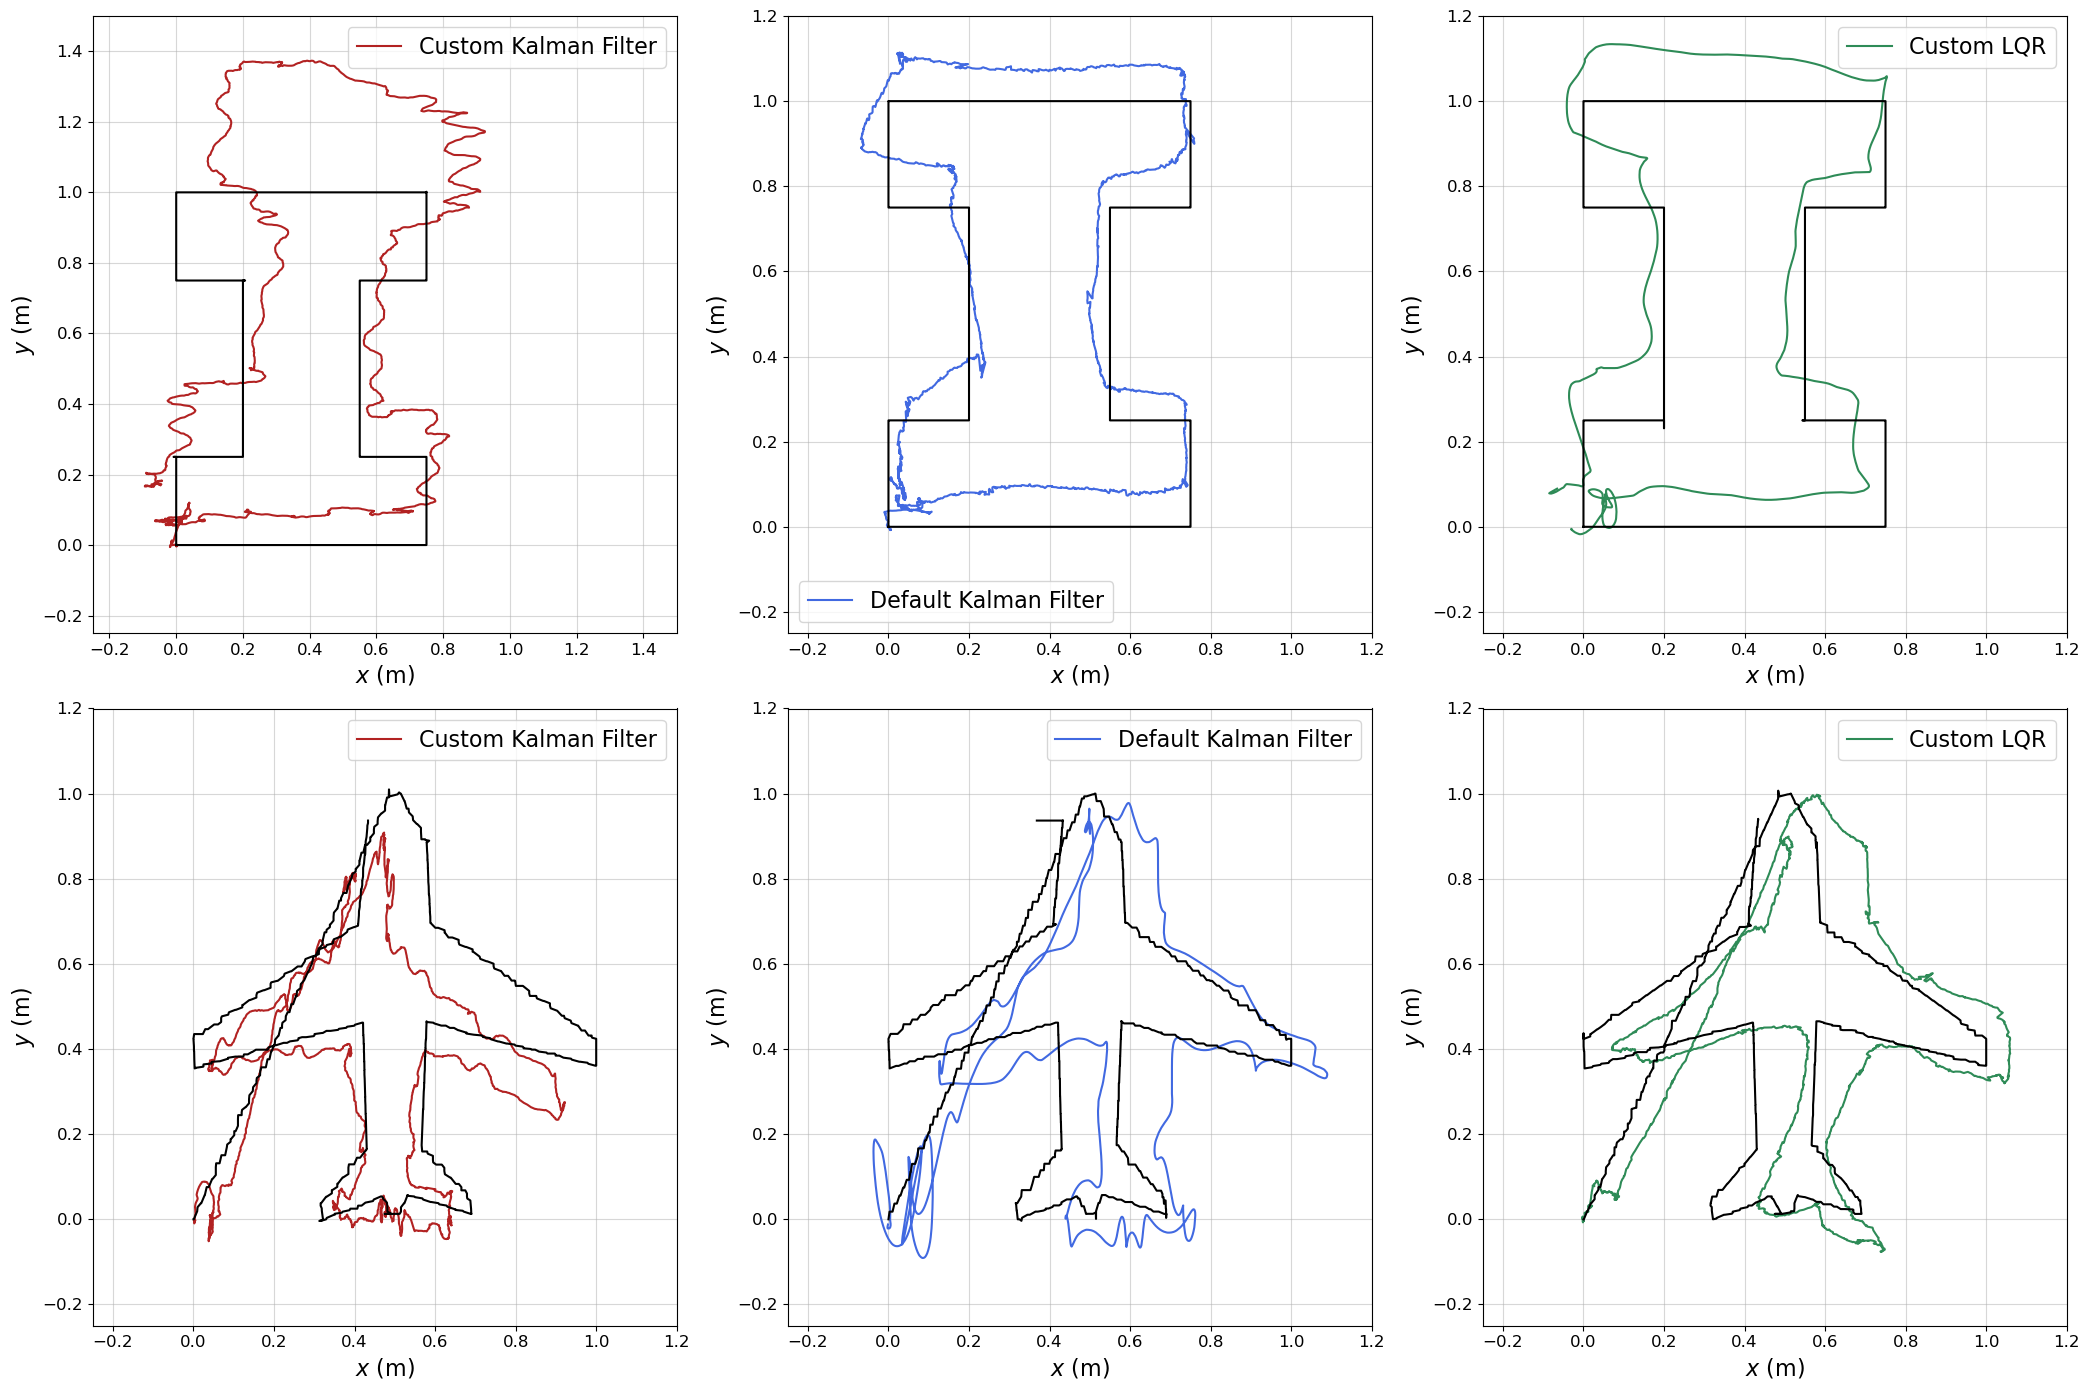

In [113]:
fig = plt.figure(figsize=(21,14), tight_layout=True)

ax1 = fig.add_subplot(2,3,1)
ax1.plot(o_y_custom1, o_x_custom1, color='firebrick', label='Custom Kalman Filter')
ax1.plot(o_y_des1, o_x_des1, color='k')
ax1.set_xlabel('$x$ (m)', fontsize=16)
ax1.set_ylabel('$y$ (m)', fontsize=16)
ax1.set_xlim(-0.25,1.5)
ax1.set_ylim(-0.25,1.5)
ax1.tick_params(labelsize=12)
ax1.grid(alpha=0.5)
ax1.legend(fontsize=16)

ax2 = fig.add_subplot(2,3,2)
ax2.plot(o_y_custom5, o_x_custom5, color='royalblue', label='Default Kalman Filter')
ax2.plot(o_y_des5, o_x_des5, color='k')
ax2.set_xlabel('$x$ (m)', fontsize=16)
ax2.set_ylabel('$y$ (m)', fontsize=16)
ax2.set_xlim(-0.25,1.2)
ax2.set_ylim(-0.25,1.2)
ax2.tick_params(labelsize=12)
ax2.grid(alpha=0.5)
ax2.legend(fontsize=16)

ax3 = fig.add_subplot(2,3,3)
ax3.plot(o_y_custom3, o_x_custom3, color='seagreen', label='Custom LQR')
ax3.plot(o_y_des3, o_x_des3, color='k')
ax3.set_xlabel('$x$ (m)', fontsize=16)
ax3.set_ylabel('$y$ (m)', fontsize=16)
ax3.set_xlim(-0.25,1.2)
ax3.set_ylim(-0.25,1.2)
ax3.tick_params(labelsize=12)
ax3.grid(alpha=0.5)
ax3.legend(fontsize=16)

ax4 = fig.add_subplot(2,3,4)
ax4.plot(o_x_custom2, o_y_custom2, color='firebrick', label='Custom Kalman Filter')
ax4.plot(o_x_des2, o_y_des2, color='k')
ax4.set_xlabel('$x$ (m)', fontsize=16)
ax4.set_ylabel('$y$ (m)', fontsize=16)
ax4.set_xlim(-0.25,1.2)
ax4.set_ylim(-0.25,1.2)
ax4.tick_params(labelsize=12)
ax4.grid(alpha=0.5)
ax4.legend(fontsize=16)

ax5 = fig.add_subplot(2,3,5)
ax5.plot(o_x_custom4, o_y_custom4, color='royalblue', label='Default Kalman Filter')
ax5.plot(o_x_des4, o_y_des4, color='k')
ax5.set_xlabel('$x$ (m)', fontsize=16)
ax5.set_ylabel('$y$ (m)', fontsize=16)
ax5.set_xlim(-0.25,1.2)
ax5.set_ylim(-0.25,1.2)
ax5.tick_params(labelsize=12)
ax5.grid(alpha=0.5)
ax5.legend(fontsize=16)

ax6 = fig.add_subplot(2,3,6)
ax6.plot(o_x_custom6, o_y_custom6, color='seagreen', label='Custom LQR')
ax6.plot(o_x_des6, o_y_des6, color='k')
ax6.set_xlabel('$x$ (m)', fontsize=16)
ax6.set_ylabel('$y$ (m)', fontsize=16)
ax6.set_xlim(-0.25,1.2)
ax6.set_ylim(-0.25,1.2)
ax6.tick_params(labelsize=12)
ax6.grid(alpha=0.5)
ax6.legend(fontsize=16)

# fig.savefig('top.png', facecolor='white', transparent=False)

### 2.2 Plot Estimated Positions and Desired Positions (Side View)

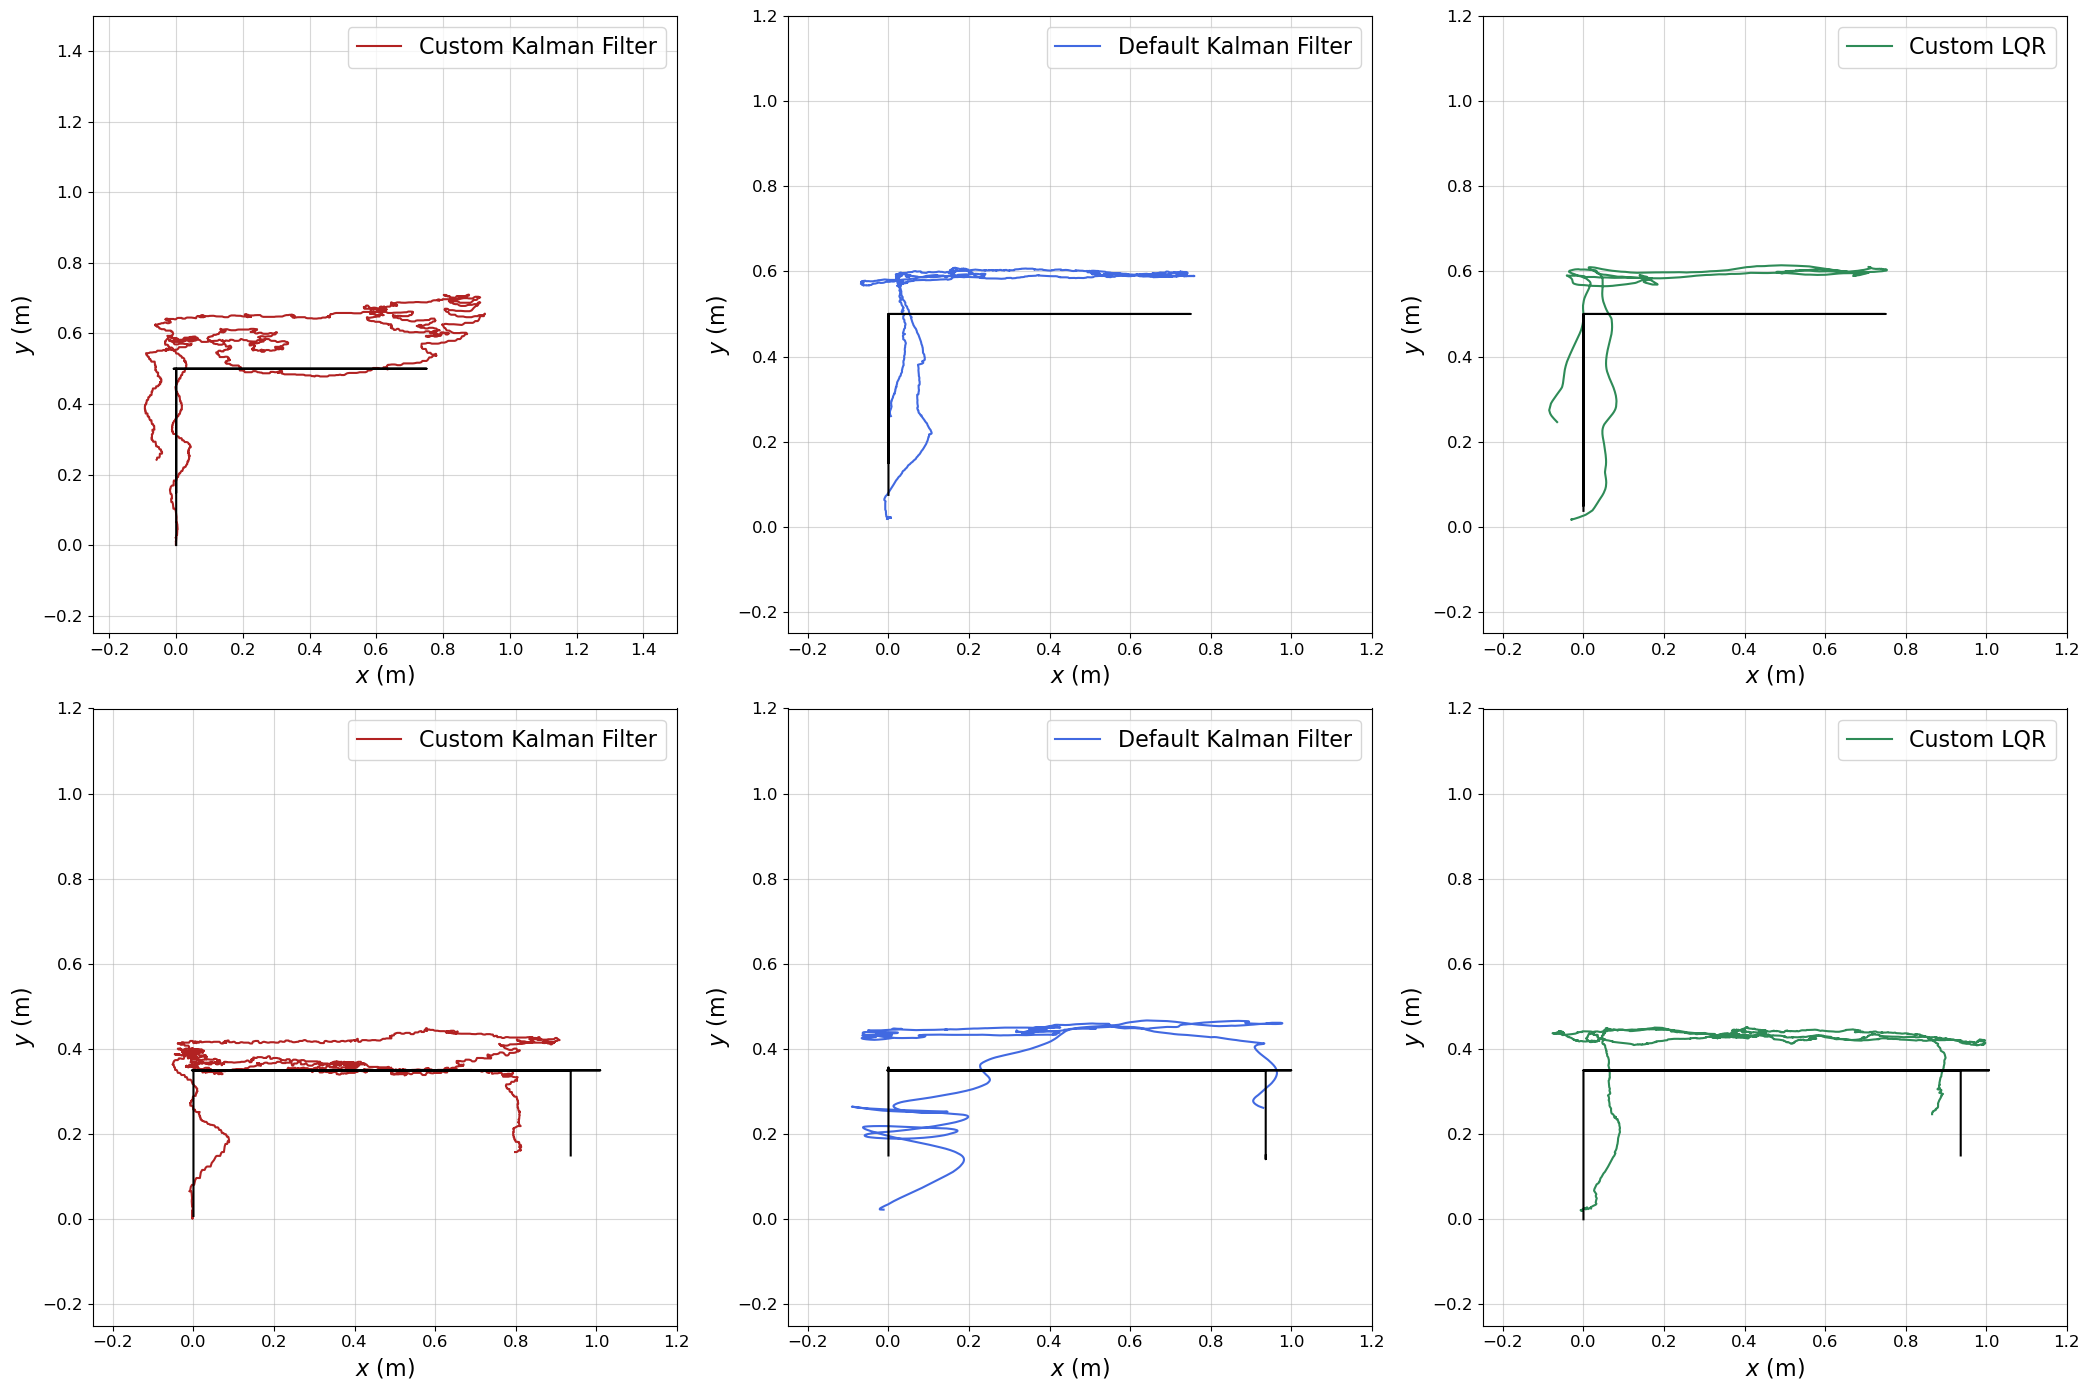

In [110]:
fig = plt.figure(figsize=(21,14), tight_layout=True)

ax1 = fig.add_subplot(2,3,1)
ax1.plot(o_y_custom1, o_z_custom1, color='firebrick', label='Custom Kalman Filter')
ax1.plot(o_y_des1, o_z_des1, color='k')
ax1.set_xlabel('$x$ (m)', fontsize=16)
ax1.set_ylabel('$y$ (m)', fontsize=16)
ax1.set_xlim(-0.25,1.5)
ax1.set_ylim(-0.25,1.5)
ax1.tick_params(labelsize=12)
ax1.grid(alpha=0.5)
ax1.legend(fontsize=16)

ax2 = fig.add_subplot(2,3,2)
ax2.plot(o_y_custom5, o_z_custom5, color='royalblue', label='Default Kalman Filter')
ax2.plot(o_y_des5, o_z_des5, color='k')
ax2.set_xlabel('$x$ (m)', fontsize=16)
ax2.set_ylabel('$y$ (m)', fontsize=16)
ax2.set_xlim(-0.25,1.2)
ax2.set_ylim(-0.25,1.2)
ax2.tick_params(labelsize=12)
ax2.grid(alpha=0.5)
ax2.legend(fontsize=16)

ax3 = fig.add_subplot(2,3,3)
ax3.plot(o_y_custom3, o_z_custom3, color='seagreen', label='Custom LQR')
ax3.plot(o_y_des3, o_z_des3, color='k')
ax3.set_xlabel('$x$ (m)', fontsize=16)
ax3.set_ylabel('$y$ (m)', fontsize=16)
ax3.set_xlim(-0.25,1.2)
ax3.set_ylim(-0.25,1.2)
ax3.tick_params(labelsize=12)
ax3.grid(alpha=0.5)
ax3.legend(fontsize=16)

ax4 = fig.add_subplot(2,3,4)
ax4.plot(o_y_custom2, o_z_custom2, color='firebrick', label='Custom Kalman Filter')
ax4.plot(o_y_des2, o_z_des2, color='k')
ax4.set_xlabel('$x$ (m)', fontsize=16)
ax4.set_ylabel('$y$ (m)', fontsize=16)
ax4.set_xlim(-0.25,1.2)
ax4.set_ylim(-0.25,1.2)
ax4.tick_params(labelsize=12)
ax4.grid(alpha=0.5)
ax4.legend(fontsize=16)

ax5 = fig.add_subplot(2,3,5)
ax5.plot(o_y_custom4, o_z_custom4, color='royalblue', label='Default Kalman Filter')
ax5.plot(o_y_des4, o_z_des4, color='k')
ax5.set_xlabel('$x$ (m)', fontsize=16)
ax5.set_ylabel('$y$ (m)', fontsize=16)
ax5.set_xlim(-0.25,1.2)
ax5.set_ylim(-0.25,1.2)
ax5.tick_params(labelsize=12)
ax5.grid(alpha=0.5)
ax5.legend(fontsize=16)

ax6 = fig.add_subplot(2,3,6)
ax6.plot(o_y_custom6, o_z_custom6, color='seagreen', label='Custom LQR')
ax6.plot(o_y_des6, o_z_des6, color='k')
ax6.set_xlabel('$x$ (m)', fontsize=16)
ax6.set_ylabel('$y$ (m)', fontsize=16)
ax6.set_xlim(-0.25,1.2)
ax6.set_ylim(-0.25,1.2)
ax6.tick_params(labelsize=12)
ax6.grid(alpha=0.5)
ax6.legend(fontsize=16)

# fig.savefig('side.png', facecolor='white', transparent=False)

# 3. Perform Error Analysis

### 3.1 Calculate RMSE Values

### 3.1.1 Custom Kalman Filter

In [114]:
### RMSE for Custom Kalman Filter wrt Default Observer averaged between block I and plane
rmse_ck = np.array([
    np.mean([rmse(o_x_custom1, o_x_default1), rmse(o_x_custom2, o_x_default2)]),
    np.mean([rmse(o_y_custom1, o_y_default1), rmse(o_y_custom2, o_y_default2)]),
    np.mean([rmse(o_z_custom1, o_z_default1), rmse(o_z_custom2, o_z_default2)]),
    np.mean([rmse(psi_custom1, psi_default1), rmse(psi_custom2, psi_default2)]),
    np.mean([rmse(theta_custom1, theta_default1), rmse(theta_custom2, theta_default2)]),
    np.mean([rmse(phi_custom1, phi_default1), rmse(phi_custom2, phi_default2)]),
    np.mean([rmse(v_x_custom1, v_x_default1), rmse(v_x_custom2, v_x_default2)]),
    np.mean([rmse(v_y_custom1, v_y_default1), rmse(v_y_custom2, v_y_default2)]),
    np.mean([rmse(v_z_custom1, v_z_default1), rmse(v_z_custom2, v_z_default2)]),
])

### 3.1.2 Custom LQR Observer

In [117]:
### RMSE for Custom LQR Observer wrt Default Observer averaged between block I and plane
rmse_lqr = np.array([
    np.mean([rmse(o_x_custom3, o_x_default3), rmse(o_x_custom4, o_x_default4)]),
    np.mean([rmse(o_y_custom3, o_y_default3), rmse(o_y_custom4, o_y_default4)]),
    np.mean([rmse(o_z_custom3, o_z_default3), rmse(o_z_custom4, o_z_default4)]),
    np.mean([rmse(psi_custom3, psi_default3), rmse(psi_custom4, psi_default4)]),
    np.mean([rmse(theta_custom3, theta_default3), rmse(theta_custom4, theta_default4)]),
    np.mean([rmse(phi_custom3, phi_default3), rmse(phi_custom4, phi_default4)]),
    np.mean([rmse(v_x_custom3, v_x_default3), rmse(v_x_custom4, v_x_default4)]),
    np.mean([rmse(v_y_custom3, v_y_default3), rmse(v_y_custom4, v_y_default4)]),
    np.mean([rmse(v_z_custom3, v_z_default3), rmse(v_z_custom4, v_z_default4)]),
])

### 3.2 Print Values

In [134]:
print(f'RMSE Values Custom Kalman')
print(f'---------------------------------------------------------------------')
print(f' o_x     o_y     o_z     psi    theta    phi     v_x     v_y     v_z')
print(f'{rmse_ck[0]:.4f}  {rmse_ck[1]:.4f}  {rmse_ck[2]:.4f}  {rmse_ck[3]:.4f}  {rmse_ck[4]:.4f}  {rmse_ck[5]:.4f}  {rmse_ck[6]:.4f}  {rmse_ck[7]:.4f}  {rmse_ck[8]:.4f}')
print(f'    ')
print(f'RMSE Values Custom LQR')
print(f'---------------------------------------------------------------------')
print(f' o_x     o_y     o_z     psi    theta    phi     v_x     v_y     v_z')
print(f'{rmse_lqr[0]:.4f}  {rmse_lqr[1]:.4f}  {rmse_lqr[2]:.4f}  {rmse_lqr[3]:.4f}  {rmse_lqr[4]:.4f}  {rmse_lqr[5]:.4f}  {rmse_lqr[6]:.4f}  {rmse_lqr[7]:.4f}  {rmse_lqr[8]:.4f}')

RMSE Values Custom Kalman
---------------------------------------------------------------------
 o_x     o_y     o_z     psi    theta    phi     v_x     v_y     v_z
0.1303  0.0563  0.0030  0.0118  0.0369  0.0387  0.0839  0.1613  0.0627
    
RMSE Values Custom LQR
---------------------------------------------------------------------
 o_x     o_y     o_z     psi    theta    phi     v_x     v_y     v_z
0.2577  0.1792  0.0085  0.0217  0.0037  0.0060  0.0477  0.0749  0.0280


In [133]:
print(f'Total Averages')
print(f'----------------------------')
print(f'Custom Kalman      Custom LQR')
print(f'    {np.mean(rmse_ck):.4f}           {np.mean(rmse_lqr):.4f}')

Total Averages
----------------------------
Custom Kalman      Custom LQR
    0.0650           0.0697
